# Entendimento da Função Lorentziana:

In [122]:
import numpy as np 
import math
import seaborn as sns
import pandas as pd

In [123]:
def lorentzFunc (x, x0, gama):
    return 1/(np.pi*gama*(1 + ((x-x0)/(gama))**2))

In [124]:
x0 = 10  # Posicão da Moda da Distribuição
gama = 1

X = np.arange(-10.0+x0, 10.0+x0, 0.1)
Y = lorentzFunc(X, x0, gama)

lorentzDF = pd.DataFrame(data={'X': X, 'Y':Y})
lorentzDF.head()

,X,Y
0,0.0,0.003152
1,0.1,0.003215
2,0.2,0.003280
3,0.3,0.003347
4,0.4,0.003417


<AxesSubplot:xlabel='X', ylabel='Y'>

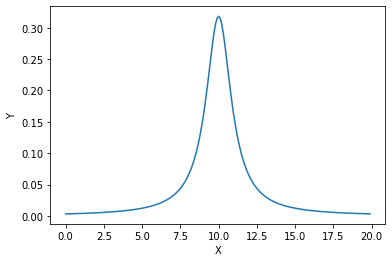

In [125]:
sns.lineplot(data=lorentzDF, x='X', y='Y')

# Criando um modelo de regressão não linear para aprender a Lorentziana (neurônios LIF)

In [126]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

In [127]:
# Seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## Criando a base de dados

In [128]:
class RegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples # number of generated samples
        feature_lst = [] # store each generated sample in a list

        # generate linear functions one by one
        for idx in range(num_samples):
            end = 20.0#float(torch.rand(1)) # random final point
            lin_vec = torch.linspace(start=0.0, end=end, steps=timesteps) # generate linear function from 0 to end
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature) # add sample to list

        self.features = torch.stack(feature_lst, dim=1) # convert list to tensor

        # option to generate linear function or square-root function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)
        
        elif mode == 'lorentz':
            gama = 1.0
            x0 = 10.0
            self.labels = lorentzFunc(self.features, x0, gama)
        else:
            raise NotImplementedError("'linear', 'sqrt', 'lorentz'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]

## Visualização da base numérica

torch.Size([50, 1, 1])


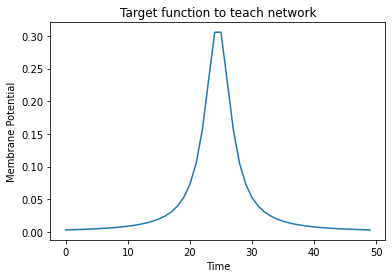

In [129]:
num_steps = 50
num_samples = 1
mode = "lorentz" # 'linear' or 'sqrt' or 'lorentz'

# generate a single data sample
dataset = RegressionDataset(timesteps=num_steps, num_samples=num_samples, mode=mode)

print(dataset.features.size())

# plot
sample = dataset.labels[:, 0, 0]
plt.plot(sample)
plt.title("Target function to teach network")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.show()

## Transformando a base de dados em um DataLoader

In [130]:
batch_size = 1 # only one sample to learn
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)

## Montando a topologia da Rede Neural

In [131]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.hidden = hidden # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)

        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)

## Instanciando a Rede Neural

In [132]:
hidden = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Net(timesteps=num_steps, hidden=hidden).to(device)

## Mapeamento Entrada-Saída sem treinamento:

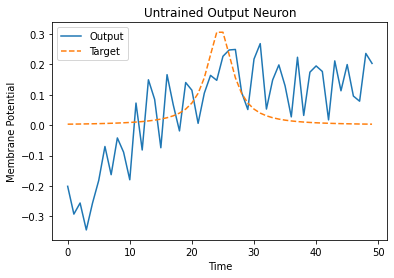

In [133]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for feature, label in train_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        feature = feature.to(device)
        label = label.to(device)
        mem = model(feature)

# plot
plt.plot(mem[:, 0, 0].cpu(), label="Output")
plt.plot(label[:, 0, 0].cpu(), '--', label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc='best')
plt.show()

## Loop de Treinamento da Rede Neural

In [138]:
num_iter = 1000 # train for 100 iterations
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()

loss_hist = [] # record loss

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            # prepare data
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(device)
            label = label.to(device)

            # forward pass
            mem = model(feature)
            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights

            # store loss
            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss) # print loss p/batch

100%|██████████| 200/200 [00:14<00:00, 14.10it/s, loss=8.294e-04]


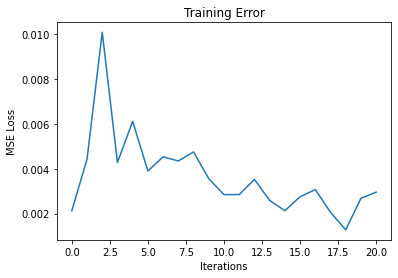

In [139]:
plt.title("Training Error")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.plot(loss_hist[0:21])
plt.show()

## Validação do Treinamento 

In [140]:
loss_function = torch.nn.L1Loss() # Use L1 loss instead

 # pause gradient calculation during evaluation
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)
    minibatch_counter = 0
    rel_err_lst = []

    # loop over data samples
    for feature, label in test_batch:

        # prepare data
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model(feature)

        # calculate relative error
        rel_err = torch.linalg.norm(
            (mem - label), dim=-1
        ) / torch.linalg.norm(label, dim=-1)
        rel_err = torch.mean(rel_err[1:, :])

        # calculate loss
        loss_val = loss_function(mem, label)

        # store loss
        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())
        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")
print(f"{'Mean rel. err.:':<{20}}{mean_rel:1.2e}")

Mean L1-loss:       1.43e-03
Mean rel. err.:     1.64e+00


## Visualização da Saída Numérica do modelo (previsto x esperado)

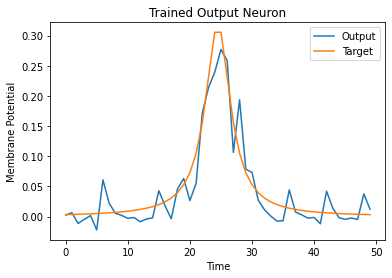

In [141]:
mem = mem.cpu()
label = label.cpu()

plt.title("Trained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
for i in range(batch_size):
    plt.plot(mem[:, i, :].cpu(), label="Output")
    plt.plot(label[:, i, :].cpu(), label="Target")
plt.legend(loc='best')
plt.show()

In [89]:
torch.save(model.state_dict(), 'regressive_snn_lorentz')

## Carregando a base de Imkx. O nfi escolhido para teste é de 11.0.

In [94]:
import os

dir_csv = '../losses'
#dir_csv_graf = '../losses_grafeno'

losses = os.listdir(dir_csv)
#graf_losses = os.listdir(dir_csv_graf)

nc = 1.0
ns = 1.98**2

pdf_losses = []
col_names = ['classif_cone_luz', 'nc', 'ns', 'nfr', 'nfi', 'freq', 'imkx', 'loss', 'img_num']

img_count = 0

for arq in losses:
    fname = dir_csv+'/'+arq
    #print(fname)
    nfr = arq.split('_')[5].split('(')[1]
    nfi = arq.split('_')[7].split(')')[0]
    pdf = pd.read_csv(fname, header=None, names=col_names[5:8])
    pdf['img_num'] = img_count
    pdf[col_names[0]] = 0
    pdf[col_names[1]] = nc
    pdf[col_names[2]] = ns
    pdf[col_names[3]] = float(nfr)
    pdf[col_names[4]] = float(nfi)
    pdf['log_loss'] = np.log10(pdf['loss'].abs())
    img_count += 1
    
    pdf_losses.append(pdf)

final_pdf = pd.concat(pdf_losses)

In [95]:
regression_base = final_pdf[['freq', 'nfi', 'imkx']]
regression_base['imkx_norm'] = (regression_base.imkx - min(regression_base.imkx))/(max(regression_base.imkx)-min(regression_base.imkx))
target_nfi = 11.0
reduced_base = regression_base[regression_base.nfi == target_nfi]

x = reduced_base['freq']
y = reduced_base['imkx_norm']

c:\Users\dmene\Anaconda3\envs\snn-pso\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Adicionando outro tipo de dados, agora usando de uma fonte externa:

In [116]:
class RegressionDataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, num_samples=1, mode=None, external_set=None):
        """Linear relation between input and output"""
        self.num_samples = num_samples # number of generated samples
        feature_lst = [] # store each generated sample in a list

        frequencies = external_set['freq'].copy()
        timesteps = frequencies.shape[0]

        # generate linear functions one by one
        for idx in range(num_samples):   
            lin_vec = torch.linspace(start=min(frequencies), end=max(frequencies), steps=timesteps) # generate linear function from 0 to end
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature) # add sample to list

        self.features = torch.stack(feature_lst, dim=1) # convert list to tensor

        # option to generate linear function or square-root function
        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)
        
        elif mode == 'lorentz':
            gama = 1.0
            x0 = 10.0
            self.labels = lorentzFunc(self.features, x0, gama)

        elif mode == 'wg_freq_imkx':
            labels = torch.tensor(external_set['imkx_norm'], dtype=torch.float)
            self.labels = labels.view(timesteps, 1, 1)

        else:
            raise NotImplementedError("'linear', 'sqrt', 'lorentz', 'wg_freq_imkx'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]

## Visualização da saída esperada ao modelo 

<class 'torch.Tensor'>


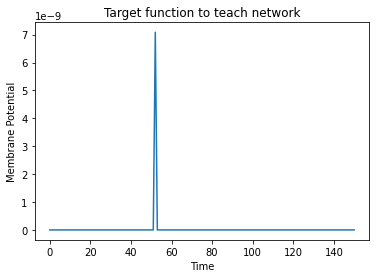

In [117]:
# generate a single data sample
dataset = RegressionDataset(num_samples=num_samples, mode='wg_freq_imkx', external_set=reduced_base)
# plot
sample = dataset.labels[:, 0, 0]
plt.plot(sample)
plt.title("Target function to teach network")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.show()

In [118]:
batch_size = 1 # only one sample to learn
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True)

## Carregando o modelo pré treinado

In [120]:
hidden = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Net(timesteps=151, hidden=hidden).to(device)

model = model.load_state_dict(torch.load('regressive_snn_lorentz'))

In [121]:
train_batch = iter(dataloader)

# run a single forward-pass
with torch.no_grad():
    for feature, label in train_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)
        feature = feature.to(device)
        label = label.to(device)
        mem = model(feature)

# plot
plt.plot(mem[:, 0, 0].cpu(), label="Output")
plt.plot(label[:, 0, 0].cpu(), '--', label="Target")
plt.title("Untrained Output Neuron")
plt.xlabel("Time")
plt.ylabel("Membrane Potential")
plt.legend(loc='best')
plt.show()

TypeError: '_IncompatibleKeys' object is not callable